In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# Define the path to your train and test data folders
train_data_path = r"D:/cnn data/train"
test_data_path = r"D:/cnn data/test"

In [3]:
def load_data(data_path, target_shape=(128, 128, 3)):
    images = []
    for foldername, subfolders, filenames in os.walk(data_path):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            img = cv2.imread(file_path)
            if img is None:
                continue
            #convert to RGB formate
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
            img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize to a common shape
            img = img.astype('float32') / 255.0  # Normalize to range [0, 1]
            images.append(img)
    return np.array(images)

In [ ]:
# Load train and test data
train_data = load_data(train_data_path)
test_data = load_data(test_data_path)
train_data.shape

In [5]:
# Add digital noise to the image dataset and clip the range from 0 to 1
def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

In [6]:
# Loading noisy data
train_noisy_data = add_noise(train_data)
test_noisy_data = add_noise(test_data)
train_noisy_data.shape

(3114, 128, 128, 3)

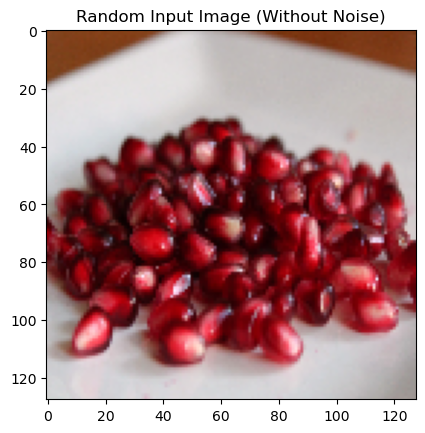

In [7]:
# Display random input image (without noise)
random_index = random.randint(0, len(train_data) - 1)
plt.imshow(train_data[random_index])
plt.title('Random Input Image (Without Noise)')
plt.show()

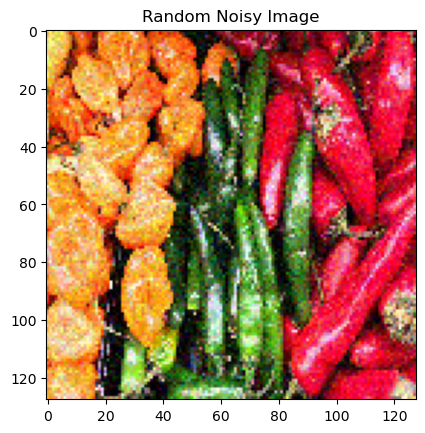

In [8]:
# Display random noisy image
plt.imshow(train_noisy_data[random.randint(0, len(train_noisy_data))])
plt.title('Random Noisy Image')
plt.show()

In [9]:
# Autoencoder model creation

#Encoder layers

input_img = Input(shape=(128, 128, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoder layers

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

#compile the model

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496 

In [10]:
# Train the model with 20 epochs 
history = autoencoder.fit(train_noisy_data, train_data, epochs=20,
                          batch_size=16, shuffle=True,
                          validation_data=(test_noisy_data, test_data))

Epoch 1/20
195/195 [==============================] - 86s 430ms/step - loss: 0.0321 - accuracy: 0.6542 - val_loss: 0.0162 - val_accuracy: 0.7271
Epoch 2/20
195/195 [==============================] - 78s 402ms/step - loss: 0.0143 - accuracy: 0.7658 - val_loss: 0.0130 - val_accuracy: 0.8095
Epoch 3/20
195/195 [==============================] - 73s 375ms/step - loss: 0.0124 - accuracy: 0.8058 - val_loss: 0.0121 - val_accuracy: 0.8288
Epoch 4/20
195/195 [==============================] - 74s 379ms/step - loss: 0.0116 - accuracy: 0.8062 - val_loss: 0.0113 - val_accuracy: 0.8011
Epoch 5/20
195/195 [==============================] - 80s 412ms/step - loss: 0.0111 - accuracy: 0.8004 - val_loss: 0.0107 - val_accuracy: 0.7927
Epoch 6/20
195/195 [==============================] - 78s 403ms/step - loss: 0.0108 - accuracy: 0.8033 - val_loss: 0.0105 - val_accuracy: 0.8235
Epoch 7/20
195/195 [==============================] - 80s 412ms/step - loss: 0.0105 - accuracy: 0.8129 - val_loss: 0.0102 - val_ac

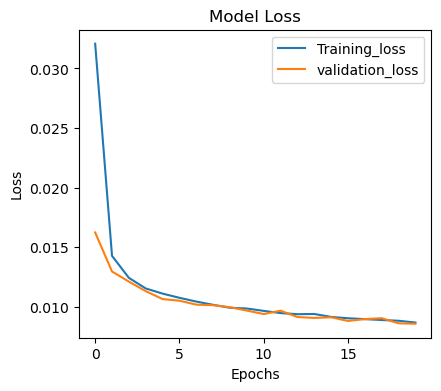

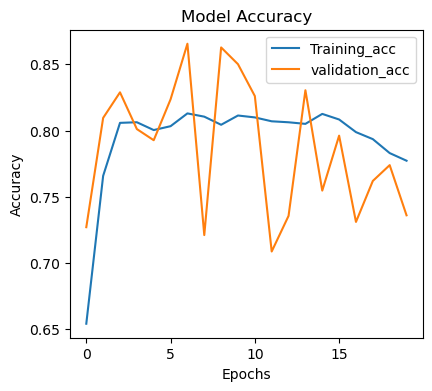

In [11]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_loss', 'validation_loss'])
plt.show()


# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_acc', 'validation_acc'])
plt.show()

In [15]:
# Predict results from the model
predicted_images = autoencoder.predict(test_noisy_data)
predicted_images.shape

12/12 [==============================] - 1s 72ms/step


(359, 128, 128, 3)

In [16]:
# Randomly select a noisy image and predict the original image
random_index = random.randint(0, len(test_noisy_data) - 1)
noisy_image = test_noisy_data[random_index]
predicted_image = predicted_images[random_index]
predicted_image.shape

(128, 128, 3)

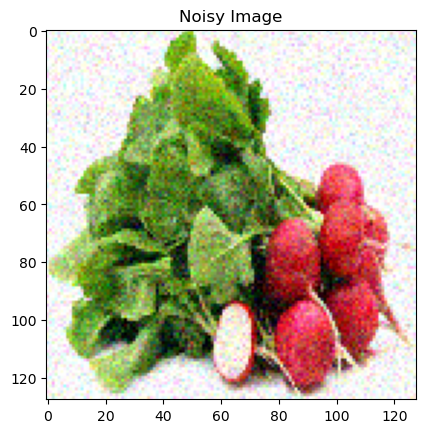

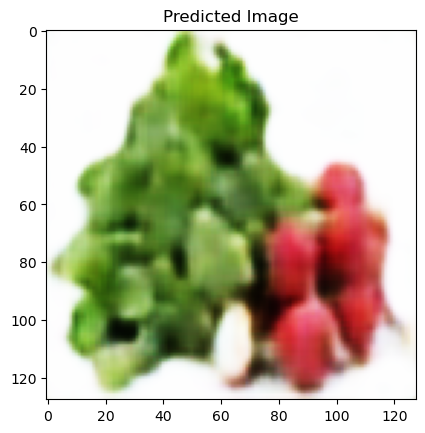

In [17]:
# Display the noisy image
plt.imshow(noisy_image)
plt.title('Noisy Image')
plt.show()

# Display the predicted image
plt.imshow(predicted_image)
plt.title('Predicted Image')
plt.show()
